In [177]:
import pandas as pd
import numpy as np
import re
import string
import spacy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [114]:
# !python -m spacy download en_core_web_sm

### Набор данных
[
Spam or Not Spam Dataset](https://www.kaggle.com/datasets/ozlerhakan/spam-or-not-spam-dataset/)

In [115]:
data = pd.read_csv('spam_or_not_spam.csv')
data = data.astype({'email':'string'})
data.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


In [116]:
data['label'].value_counts()

label
0    2500
1     500
Name: count, dtype: int64

In [117]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2999 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   2999 non-null   string
 1   label   2999 non-null   int64 
dtypes: int64(1), string(1)
memory usage: 70.3 KB


### Очистка

Стоп-слова для английского языка в spaCy

In [118]:
nlp = spacy.load("en_core_web_sm")
stopwords = nlp.Defaults.stop_words
print(f'Spacy english stopwords size: {len(stopwords)}', end='\n\n')
' '.join(stopwords)

Spacy english stopwords size: 326



"could ’re hereafter towards if amount own amongst seems ’ll ours may unless his being twelve only from many wherever yourself whole i between keep me empty eight can hence by few will sometime themselves everywhere mine else has along get then using her bottom never onto most the 've how thence too though during without hereby against this becomes under already not used formerly whom here fifteen whether up above herself six nowhere re every thru meanwhile them whence been name whatever you to would its thus front whoever him nor alone via cannot moreover had until below nothing must us on ten put last least four throughout well n’t almost your ‘m around but both each am nine which a is neither quite yours for seeming ourselves take ’ve everything while again in beyond herein when became whose before ’d fifty their mostly it ’m n't our ‘d ‘s does they next out 'd anywhere one my upon hereupon however as sometimes than others just doing ‘ll anyhow that such since might done side three 

Атрибуты [Token](https://spacy.io/api/token#attributes)

In [119]:
%%time

data['cleaned_text'] = data['email'].apply(
    lambda x: ' '.join(
        token.lemma_.lower() for token in nlp(x) if
        not token.is_stop
        and not token.is_punct
        and not token.is_digit
        and not token.like_email
        and not token.like_num
        and not token.is_space
    )
)
data.head()

CPU times: total: 2min 45s
Wall time: 2min 48s


,email,label,cleaned_text
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0,date d number aug number number number number ...
1,martin a posted tassos papadopoulos the greek ...,0,martin post tassos papadopoulo greek sculptor ...
2,man threatens explosion in moscow thursday aug...,0,man threaten explosion moscow thursday august ...
3,klez the virus that won t die already the most...,0,klez virus win t die prolific virus klez conti...
4,in adding cream to spaghetti carbonara which ...,0,add cream spaghetti carbonara effect pasta mak...


#### CountVectorizer

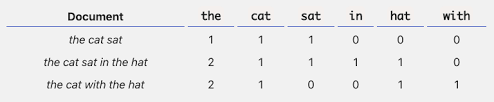

- приводит к нижнему регистру
- проводит токенизацию - `r"(?u)\b\w\w+\b"` (токены из 2 или более буквенно-цифровых символов, пунктуация полностью игнорируется и всегда рассматривается как разделитель токенов)
  - `(?u)` - флаг Unicode
  - `\b` - граница слова
  - `\w` - символы, которые могут входить в состав слов, включая числа и подчёркивание
  - `\+` - 1 и более повторений предшествующего выражения
- фильтрует стоп-слова

##### Train/test split & fit

In [120]:
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_text'], data['label'], random_state=2023)

In [121]:
vectorizer = CountVectorizer(max_df=0.7, min_df=0.003) # max_df фильтрует corpus-specific stop words
X_train_vectorized = vectorizer.fit_transform(X_train) 
X_test_vectorized = vectorizer.transform(X_test)

##### Разреженное представление результата

Поскольку в большинстве документов обычно используется очень небольшое подмножество слов, используемых в корпусе, результирующая матрица будет иметь много нулевых значений признаков (обычно более 99% из них).

Чтобы оптимально хранить такую матрицу в памяти, а также ускорить алгебраические операции с матрицей/вектором, обычно используют разреженное представление, такое как реализации, доступные в пакете scipy.sparse.


[Sparse matrices (scipy.sparse)](https://docs.scipy.org/doc/scipy/reference/sparse.html)

**CSR** - Compressed Sparse Row

**COO** - COOrdinate format

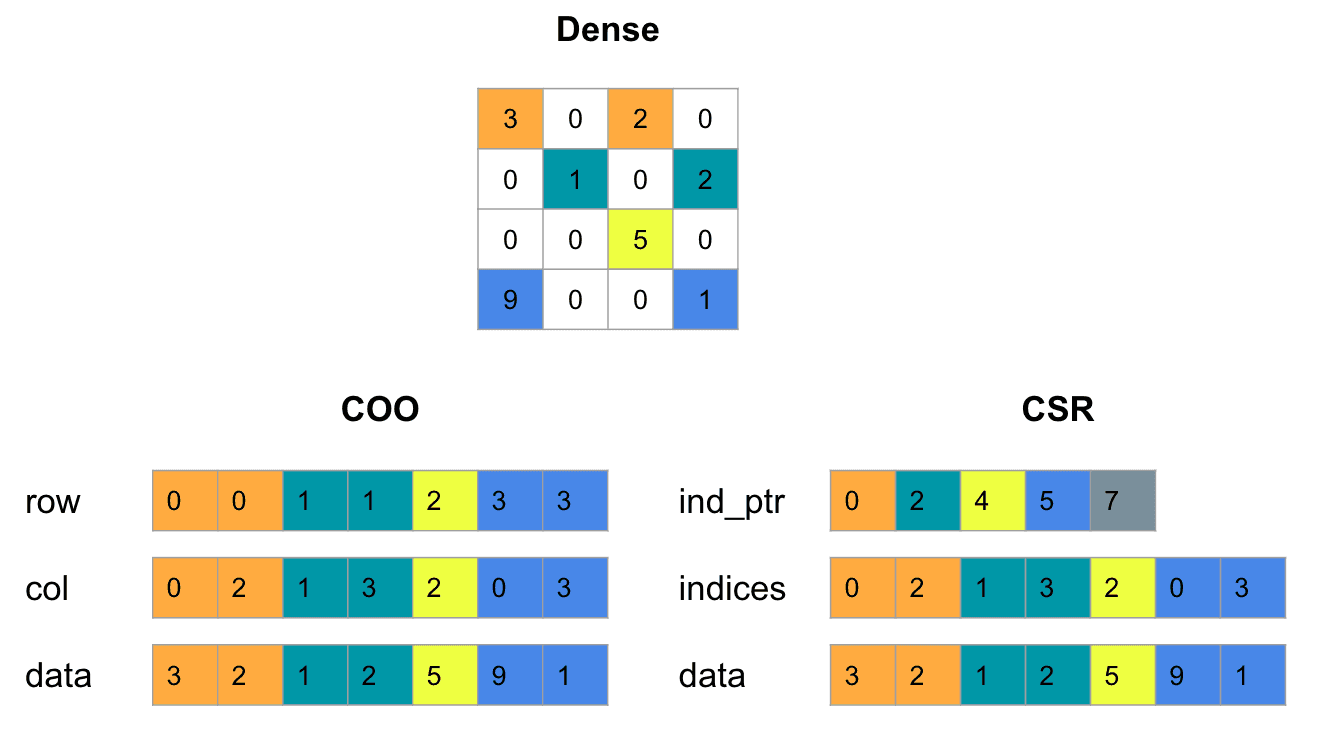

In [122]:
X_train_vectorized

<2249x3788 sparse matrix of type '<class 'numpy.int64'>'
	with 131357 stored elements in Compressed Sparse Row format>

In [123]:
vectorizer.get_feature_names_out()

array(['aa', 'aaron', 'abandon', ..., 'zone', 'zope', 'zzzz'],
      dtype=object)

In [124]:
pd.DataFrame(X_train_vectorized.toarray(), columns=vectorizer.get_feature_names_out()).head()

,aa,aaron,abandon,ability,able,abroad,absence,absolute,absolutely,abstract,...,yesterday,yield,york,young,yup,ziggy,zip,zone,zope,zzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### Бейзлайн

Константное предсказание

In [125]:
dummy_clf = DummyClassifier(strategy="most_frequent").fit(X_train_vectorized, y_train)
preds = dummy_clf.predict(X_test_vectorized)
print(classification_report(y_test, preds, zero_division=0))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       616
           1       0.00      0.00      0.00       134

    accuracy                           0.82       750
   macro avg       0.41      0.50      0.45       750
weighted avg       0.67      0.82      0.74       750



Логистическая регрессия

In [152]:
logreg = LogisticRegression().fit(X_train_vectorized, y_train)
preds_count_vec = logreg.predict(X_test_vectorized)
print(classification_report(y_test, preds_count_vec))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       616
           1       0.95      0.93      0.94       134

    accuracy                           0.98       750
   macro avg       0.97      0.96      0.96       750
weighted avg       0.98      0.98      0.98       750



##### Переопределение токенизатора, препроцессинга

In [153]:
def custom_tokenize(text):
  text = re.sub(r'[^a-zA-Z ]', '', text)
  return text.split()

In [154]:
custom_vectorizer = CountVectorizer(
    max_df=0.7,
    min_df=0.003,
    tokenizer=custom_tokenize, # аналогично можно переопределить preprocessor
)
X_train_vectorized = custom_vectorizer.fit_transform(X_train)
X_test_vectorized = custom_vectorizer.transform(X_test)

c:\Users\User\PycharmProjects\nlp_course\venv\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [155]:
logreg = LogisticRegression().fit(X_train_vectorized, y_train)
preds = logreg.predict(X_test_vectorized)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       616
           1       0.95      0.93      0.94       134

    accuracy                           0.98       750
   macro avg       0.97      0.96      0.96       750
weighted avg       0.98      0.98      0.98       750



In [156]:
print(classification_report(y_test, preds_count_vec))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       616
           1       0.95      0.93      0.94       134

    accuracy                           0.98       750
   macro avg       0.97      0.96      0.96       750
weighted avg       0.98      0.98      0.98       750



Стало работать хуже с новым токенизатором.

### Tf-Idf

В объемном корпусе некоторые слова будут присутствовать в большом количестве документов (текстов), а значит, они несут очень мало значимой информации о фактическом содержании документа.

Для решения этой проблемы можно использовать Tf-Idf подход

Цель использования tf-idf состоит в том, чтобы уменьшить влияние токенов, которые очень часто встречаются в данном корпусе и, следовательно, эмпирически менее информативны, чем признаки, которые встречаются малой части корпуса



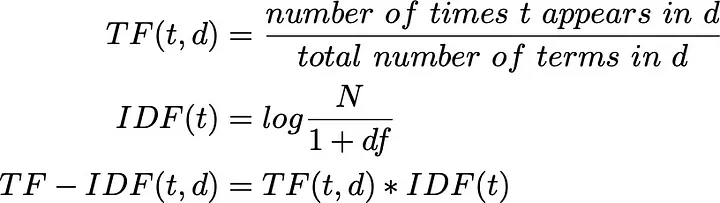

#### Отличия в реализации Sklearn

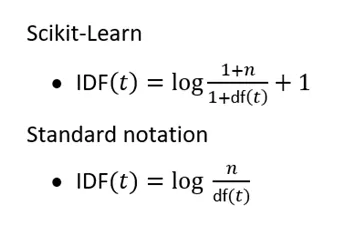

Также в Scikit-Learn результирующие векторы TF-IDF нормализуются по евклидовой норме, что облегчает расчет cosine similarity:
`The cosine similarity between two vectors is their dot product when l2 norm has been applied`

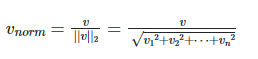

In [157]:
pipe = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer()),
        ('clf', LogisticRegression())
    ]
).fit(X_train, y_train)
preds = pipe.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       616
           1       1.00      0.77      0.87       134

    accuracy                           0.96       750
   macro avg       0.98      0.88      0.92       750
weighted avg       0.96      0.96      0.96       750



Сравним с CountVectorizer

In [159]:
print(classification_report(y_test, preds_count_vec))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       616
           1       0.95      0.93      0.94       134

    accuracy                           0.98       750
   macro avg       0.97      0.96      0.96       750
weighted avg       0.98      0.98      0.98       750



#### Оптимизация гиперпараметров пайплайна целиком - HalvingGridSearchCV

##### Логистическая регрессия

In [160]:
pipe = Pipeline(
    steps=[
        ('counter', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', LogisticRegression())
    ]
)

In [161]:
parameter_grid = {
    "counter__max_df": np.linspace(0.3, 0.7, 10),
    "counter__min_df": [0.0, 0.001, 0.003, 0.005],
    "counter__ngram_range": ((1, 1), (1, 2)),  # слова или биграммы
    "tfidf__norm": ("l1", "l2"),
    "clf__C": np.linspace(0.1, 1, 10),
}

In [162]:
%%time

grid_search = HalvingGridSearchCV(
    pipe,
    param_grid=parameter_grid,
    n_jobs=-1,
    verbose=1,
    cv=5,
    scoring='accuracy',
    random_state=42,
)
grid_search.fit(X_train, y_train)

n_iterations: 6
n_required_iterations: 7
n_possible_iterations: 6
min_resources_: 8
max_resources_: 2249
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1600
n_resources: 8
Fitting 2 folds for each of 1600 candidates, totalling 3200 fits


c:\Users\User\PycharmProjects\nlp_course\venv\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
1600 fits failed out of a total of 3200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\User\PycharmProjects\nlp_course\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\User\PycharmProjects\nlp_course\venv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\User\PycharmProjects\nlp_course\venv\lib\site-packages\sklearn\pipeline.py", line 42

----------
iter: 1
n_candidates: 534
n_resources: 24
Fitting 2 folds for each of 534 candidates, totalling 1068 fits


c:\Users\User\PycharmProjects\nlp_course\venv\lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.52272727 0.56818182 0.65909091]
  warnings.warn(
c:\Users\User\PycharmProjects\nlp_course\venv\lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the train scores are non-finite: [       nan        nan        nan ... 0.90909091 0.90909091 0.90909091]
  warnings.warn(


----------
iter: 2
n_candidates: 178
n_resources: 72
Fitting 2 folds for each of 178 candidates, totalling 356 fits


c:\Users\User\PycharmProjects\nlp_course\venv\lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.83214286 0.83214286 0.83214286]
  warnings.warn(
c:\Users\User\PycharmProjects\nlp_course\venv\lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the train scores are non-finite: [       nan        nan        nan ... 0.83214286 0.83214286 0.83214286]
  warnings.warn(


----------
iter: 3
n_candidates: 60
n_resources: 216
Fitting 2 folds for each of 60 candidates, totalling 120 fits


c:\Users\User\PycharmProjects\nlp_course\venv\lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [      nan       nan       nan ... 0.8511163 0.8511163 0.8511163]
  warnings.warn(
c:\Users\User\PycharmProjects\nlp_course\venv\lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the train scores are non-finite: [      nan       nan       nan ... 0.8511163 0.8511163 0.8511163]
  warnings.warn(


----------
iter: 4
n_candidates: 20
n_resources: 648
Fitting 2 folds for each of 20 candidates, totalling 40 fits


c:\Users\User\PycharmProjects\nlp_course\venv\lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.85469461 0.85469461 0.86859783]
  warnings.warn(
c:\Users\User\PycharmProjects\nlp_course\venv\lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the train scores are non-finite: [       nan        nan        nan ... 0.85469461 0.85469461 0.87941941]
  warnings.warn(


----------
iter: 5
n_candidates: 7
n_resources: 1944
Fitting 2 folds for each of 7 candidates, totalling 14 fits


c:\Users\User\PycharmProjects\nlp_course\venv\lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.83787714 0.85280013 0.93617002]
  warnings.warn(
c:\Users\User\PycharmProjects\nlp_course\venv\lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the train scores are non-finite: [       nan        nan        nan ... 0.83787714 0.85125639 0.96191244]
  warnings.warn(


CPU times: total: 1min 18s
Wall time: 2min 3s


HalvingGridSearchCV(cv=2,
                    estimator=Pipeline(steps=[('counter', CountVectorizer()),
                                              ('tfidf', TfidfTransformer()),
                                              ('clf', LogisticRegression())]),
                    n_jobs=-1,
                    param_grid={'clf__C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                'counter__max_df': array([0.3       , 0.34444444, 0.38888889, 0.43333333, 0.47777778,
       0.52222222, 0.56666667, 0.61111111, 0.65555556, 0.7       ]),
                                'counter__min_df': [0.0, 0.001, 0.003, 0.005],
                                'counter__ngram_range': ((1, 1), (1, 2)),
                                'tfidf__norm': ('l1', 'l2')},
                    random_state=42, scoring='accuracy', verbose=1)

In [163]:
plt.rcParams["figure.figsize"] = (12, 8)

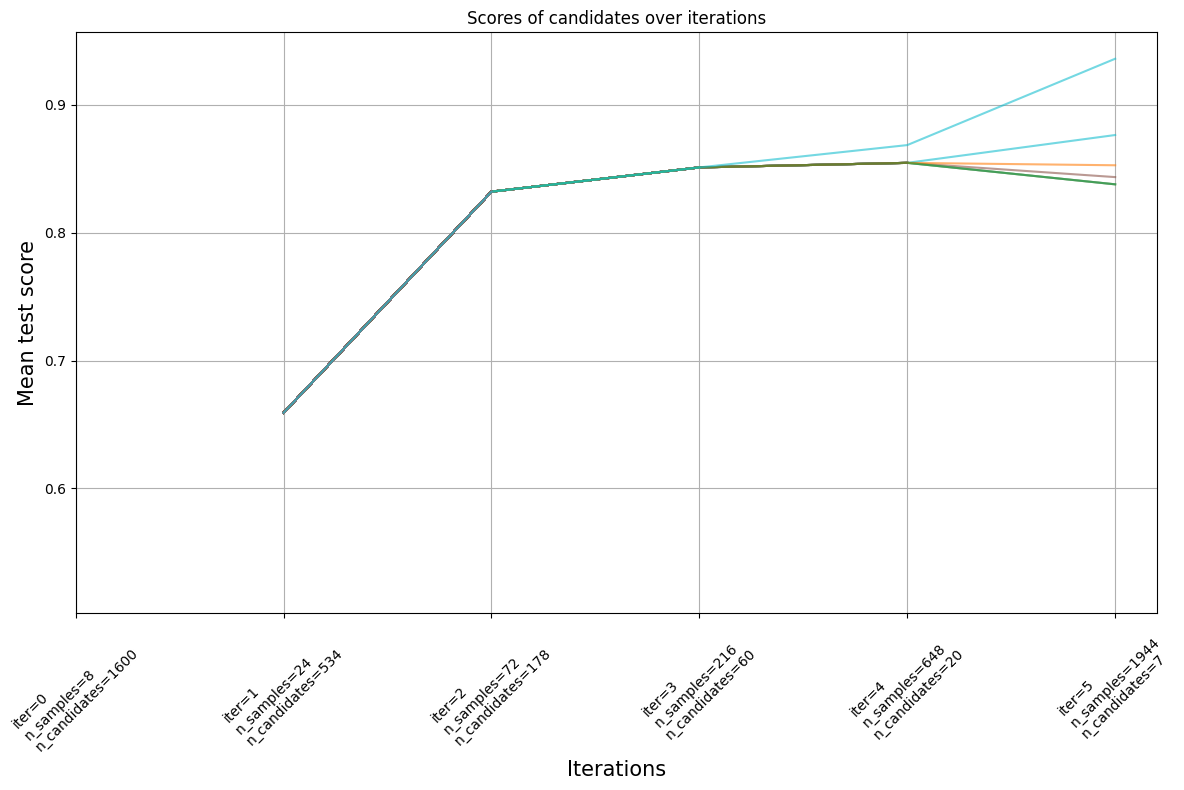

In [164]:
results = pd.DataFrame(grid_search.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter",
    columns="params_str",
     values="mean_test_score",
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={grid_search.n_resources_[i]}\nn_candidates={grid_search.n_candidates_[i]}"
    for i in range(grid_search.n_iterations_)
]

ax.set_xticks(range(grid_search.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("Mean test score", fontsize=15)
ax.set_xlabel("Iterations", fontsize=15)
plt.tight_layout()
plt.grid()
plt.show()

In [165]:
grid_search.best_score_

0.9361700211482795

In [166]:
preds = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       616
           1       1.00      0.85      0.92       134

    accuracy                           0.97       750
   macro avg       0.98      0.93      0.95       750
weighted avg       0.97      0.97      0.97       750



In [167]:
##### Дерево решений

In [178]:
pipe = Pipeline(
    steps=[
        ('counter', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', DecisionTreeClassifier())
    ]
)

parameter_grid = {
    "counter__max_df": np.linspace(0.3, 0.7, 10),
    "counter__min_df": [0.0, 0.001, 0.003, 0.005],
    "counter__ngram_range": ((1, 1), (1, 2)),  # слова или биграммы
    "tfidf__norm": ("l1", "l2")
}


In [179]:
%%time

grid_search = HalvingGridSearchCV(
    pipe,
    param_grid=parameter_grid,
    n_jobs=-1,
    verbose=1,
    cv=5,
    scoring='accuracy',
    random_state=42,
)
grid_search.fit(X_train, y_train)

preds = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, preds))

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 27
max_resources_: 2249
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 160
n_resources: 27
Fitting 5 folds for each of 160 candidates, totalling 800 fits
----------
iter: 1
n_candidates: 54
n_resources: 81
Fitting 5 folds for each of 54 candidates, totalling 270 fits
----------
iter: 2
n_candidates: 18
n_resources: 243
Fitting 5 folds for each of 18 candidates, totalling 90 fits
----------
iter: 3
n_candidates: 6
n_resources: 729
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 4
n_candidates: 2
n_resources: 2187
Fitting 5 folds for each of 2 candidates, totalling 10 fits
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       616
           1       0.81      0.92      0.86       134

    accuracy                           0.95       750
   macro avg       0.90      0.94      0.92       750
weighted avg 

##### Наивный Байесовский классификатор

In [ ]:
pipe = Pipeline(
    steps=[
        ('counter', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB())
    ]
)

parameter_grid = {
    "counter__max_df": np.linspace(0.3, 0.7, 10),
    "counter__min_df": [0.0, 0.001, 0.003, 0.005],
    "counter__ngram_range": ((1, 1), (1, 2)),  # слова или биграммы
    "tfidf__norm": ("l1", "l2"),
    "clf__C": np.linspace(0.1, 1, 10),
}


In [ ]:
%%time

grid_search = HalvingGridSearchCV(
    pipe,
    param_grid=parameter_grid,
    n_jobs=-1,
    verbose=1,
    cv=5,
    scoring='accuracy',
    random_state=42,
)
grid_search.fit(X_train, y_train)

preds = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, preds))